# Function parameter estimation

Let us consider the family of functions
$$y = f(t) := \alpha \sin (\beta t + \gamma),$$
where $\alpha, \beta, \gamma \in [0, 50]$.

Given a particular realization of $f(t)$, can we deduce the parameters $\alpha, \beta, \gamma$? More concretely, can we come up with an optimal neural network architecture for deducing these parameters?

## Preliminaries

We will use the usual suite of machine learning libraries,

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics

import keras
import tensorflow as tf
from tensorflow.python.keras import backend

We'll be running on a machine with six CPUs and one GPU, so we might as well inform TensorFlow about them:

In [3]:
config = tf.compat.v1.ConfigProto(device_count={'GPU': 1, 'CPU': 6})
sess = tf.compat.v1.Session(config=config)
backend.set_session(sess)

To check whether in each instance we are running on a CPU or on a GPU, we can set `tf.debugging.set_log_device_placement(True)`. Indeed, that's how we originally ran this code. However, since this produces a lot of debug output, we will set...

In [4]:
tf.debugging.set_log_device_placement(False)

For reproducibility, we fix the random seed:

In [5]:
np.random.seed(42)

In [6]:
tf.random.set_seed(42)

Each realization of $f(t)$ will contain $n$ points:

In [7]:
n = 1000

The parameters that we want to estimate are $\alpha, \beta, \gamma$, so

In [8]:
parameter_count = 3

We will use `iter_count` iterations in our machine learning procedures:

In [9]:
iter_count = 3000

## Data generation

We can generate pseudorandom parameters using

In [10]:
def generate_parameters():
    parameters = {}
    parameters['alpha'] = np.random.uniform(low=0., high=50.)
    parameters['beta'] = np.random.uniform(low=0., high=50.)
    parameters['gamma'] = np.random.uniform(low=0., high=50.)
    return parameters

We pick equally spaced points $t$ in $[0, 2 \pi]$:

In [11]:
ts = np.linspace(0., 2. * np.pi, n)

Given these points and the values of the parameters $\alpha, \beta, \gamma$, the following function will generate $y = f(t)$:

In [12]:
def generate_ys(ts, alpha=1., beta=1., gamma=0.):
    return alpha * np.sin(beta * ts) + gamma

Let us examine some members of this function family.

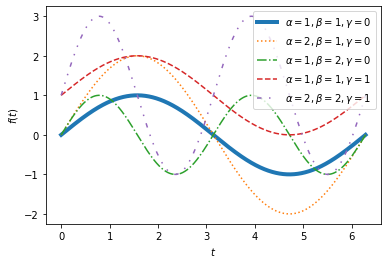

In [13]:
ys1 = generate_ys(ts)
plt.plot(ts, ys1, linestyle='-', linewidth=4, label=r'$\alpha=1, \beta=1, \gamma=0$')
ys2 = generate_ys(ts, alpha=2)
plt.plot(ts, ys2, linestyle=':', label=r'$\alpha=2, \beta=1, \gamma=0$')
ys2 = generate_ys(ts, beta=2)
plt.plot(ts, ys2, linestyle='-.', label=r'$\alpha=1, \beta=2, \gamma=0$')
ys3 = generate_ys(ts, gamma=1)
plt.plot(ts, ys3, linestyle='--', label=r'$\alpha=1, \beta=1, \gamma=1$')
ys4 = generate_ys(ts, alpha=2, beta=2, gamma=1)
plt.plot(ts, ys4, linestyle=(0, (3, 5, 1, 5, 1, 5)), label=r'$\alpha=2, \beta=2, \gamma=1$')
plt.xlabel('$t$')
plt.ylabel('$f(t)$')
plt.legend();

## Training the model

We will use the following function to train our models:

In [13]:
def train_model(model, n, batch_count, cnn=False, parameter=['alpha', 'beta', 'gamma']):
    losses = []
    for i in range(batch_count):
        inputs = []
        outputs = []
        for j in range(32):
            parameters = generate_parameters()
            ts = np.linspace(0., 2. * np.pi, n)
            ys = generate_ys(ts, **parameters)
            ys = (ys - (-100.)) / (100. - (-100.)) - .5
            an_input = ys
            inputs.append(an_input)
            an_output = np.array([parameters[p] for p in parameter])
            an_output /= 50.
            outputs.append(an_output)
        the_inputs = np.array(inputs)
        the_outputs = np.array(outputs)
        if cnn:
            the_inputs = np.reshape(the_inputs, (np.shape(the_inputs)[0], np.shape(the_inputs)[1], 1))
        history = model.fit(the_inputs, the_outputs)
        losses.append(history.history['loss'][0])
    return losses

Notice that the data is scaled using `ys = (ys - (-100.)) / (100. - (-100.)) - .5`. This is essential for the convergence of the neural networks.

We will test our models, out-of-sample, on generated data:

In [14]:
def test_model(model, n, sample_count, cnn=False, parameter=['alpha', 'beta', 'gamma']):
    results = {}
    for p in parameter: results[f'true_{p}'] = []
    the_inputs = []
    for i in range(sample_count):
        parameters = generate_parameters()
        for p in parameter: results[f'true_{p}'].append(parameters[p])
        ys = generate_ys(ts, **parameters)
        ys = (ys - (-100.)) / (100. - (-100.)) - .5
        the_inputs.append(ys)
    the_inputs = np.array(the_inputs)
    if cnn: the_inputs = np.reshape(the_inputs, (np.shape(the_inputs)[0], np.shape(the_inputs)[1], 1))
    the_outputs = model.predict(the_inputs)
    the_outputs *= 50.
    for i, p in enumerate(parameter):
        results[f'predicted_{p}'] = the_outputs[:,i]
        results[f'r2_score_{p}'] = sklearn.metrics.r2_score(results[f'true_{p}'], results[f'predicted_{p}'])
    return results

## Deep FCN

We first consider a deep fully connected network architecture.

In [16]:
model = keras.Sequential()
model.add(keras.layers.Dense(64, activation='relu', input_dim=n))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(parameter_count, activation='linear'))

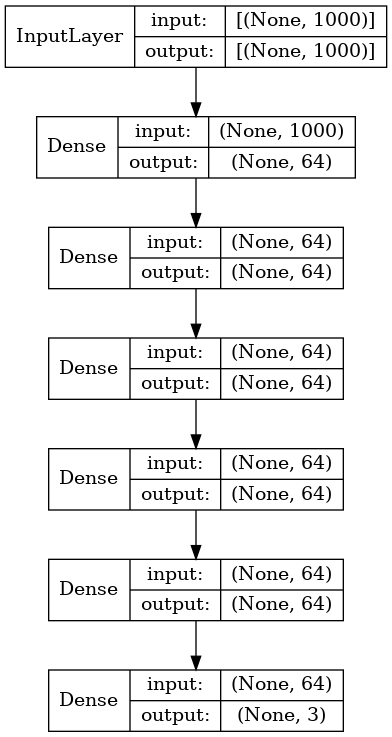

In [25]:
keras.utils.plot_model(model, show_layer_names=False, show_shapes=True)

In [17]:
optimizer = keras.optimizers.SGD(lr=0.01)

In [18]:
model.compile(loss='mse', optimizer=optimizer)

In [18]:
deep_fcn_losses = train_model(model=model, n=n, batch_count=iter_count)

1/1 [==============================] - 0s 3ms/step - loss: 0.0271


Let's examine the evolution of the losses:

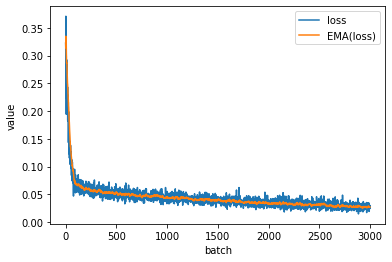

In [19]:
plt.plot(deep_fcn_losses, label='loss')
plt.plot(pd.Series(deep_fcn_losses).ewm(alpha=.1).mean(), label='EMA(loss)')
plt.xlabel('batch')
plt.ylabel('value')
plt.legend();

In [20]:
results = test_model(model=model, n=n, sample_count=iter_count)

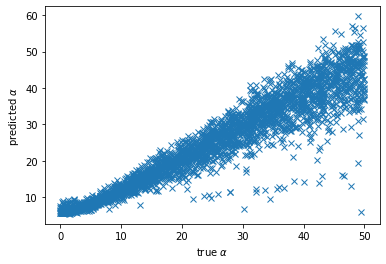

In [21]:
plt.plot(results['true_alpha'], results['predicted_alpha'], 'x')
plt.xlabel(r'true $\alpha$')
plt.ylabel(r'predicted $\alpha$');

In [22]:
results['r2_score_alpha']

0.8910842975379478

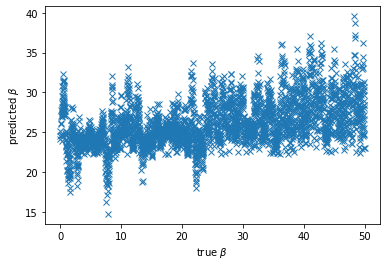

In [23]:
plt.plot(results['true_beta'], results['predicted_beta'], 'x')
plt.xlabel(r'true $\beta$')
plt.ylabel(r'predicted $\beta$');

In [24]:
results['r2_score_beta']

0.14332334988363693

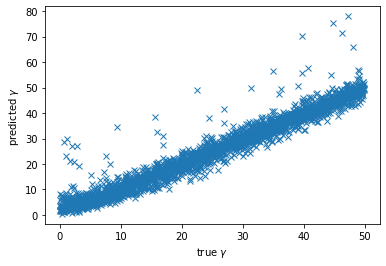

In [25]:
plt.plot(results['true_gamma'], results['predicted_gamma'], 'x')
plt.xlabel(r'true $\gamma$')
plt.ylabel(r'predicted $\gamma$');

In [26]:
results['r2_score_gamma']

0.956412046937917

## Shallow FCN

Next, we'll try a shallow fully connected network architecture.

In [26]:
model = keras.Sequential()
model.add(keras.layers.Dense(64, activation='relu', input_dim=n))
model.add(keras.layers.Dense(parameter_count, activation='linear'))

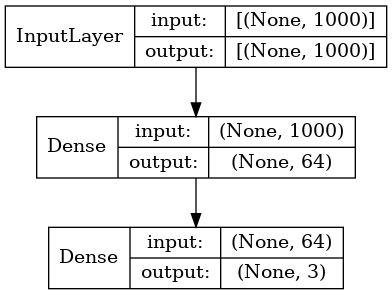

In [27]:
keras.utils.plot_model(model, show_layer_names=False, show_shapes=True)

In [28]:
optimizer = keras.optimizers.SGD(lr=0.01)

In [29]:
model.compile(loss='mse', optimizer=optimizer)

In [30]:
shallow_fcn_losses = train_model(model=model, n=n, batch_count=iter_count)

1/1 [==============================] - 0s 2ms/step - loss: 0.0095


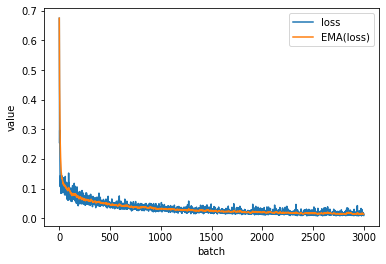

In [31]:
plt.plot(shallow_fcn_losses, label='loss')
plt.plot(pd.Series(shallow_fcn_losses).ewm(alpha=.1).mean(), label='EMA(loss)')
plt.xlabel('batch')
plt.ylabel('value')
plt.legend();

In [32]:
results = test_model(model=model, n=n, sample_count=iter_count)

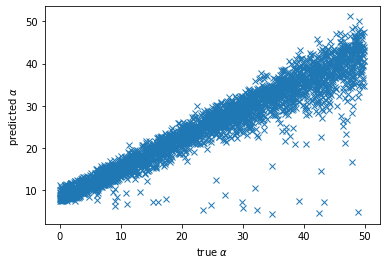

In [33]:
plt.plot(results['true_alpha'], results['predicted_alpha'], 'x')
plt.xlabel(r'true $\alpha$')
plt.ylabel(r'predicted $\alpha$');

In [34]:
results['r2_score_alpha']

0.8448916879948077

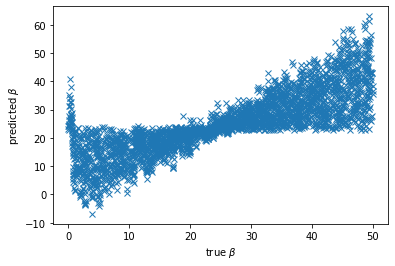

In [35]:
plt.plot(results['true_beta'], results['predicted_beta'], 'x')
plt.xlabel(r'true $\beta$')
plt.ylabel(r'predicted $\beta$');

In [36]:
results['r2_score_beta']

0.6707377315192526

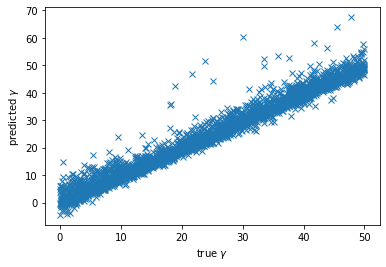

In [37]:
plt.plot(results['true_gamma'], results['predicted_gamma'], 'x')
plt.xlabel(r'true $\gamma$')
plt.ylabel(r'predicted $\gamma$');

In [38]:
results['r2_score_gamma']

0.9660987336891912

## Deep CNN

Now let's try a deep convolutional neural network:

In [28]:
model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=64, kernel_size=32, activation='relu', input_shape=(n, 1)))
model.add(keras.layers.Conv1D(filters=32, kernel_size=32, activation='relu'))
model.add(keras.layers.Conv1D(filters=16, kernel_size=32, activation='relu'))
model.add(keras.layers.Conv1D(filters=8, kernel_size=23, activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(parameter_count, activation='linear'))

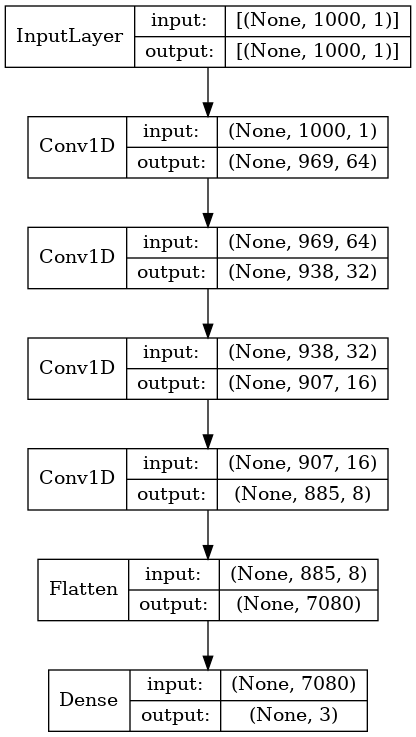

In [29]:
keras.utils.plot_model(model, show_layer_names=False, show_shapes=True)

In [40]:
optimizer = keras.optimizers.SGD(lr=0.01)

In [41]:
model.compile(loss='mse', optimizer=optimizer)

In [42]:
deep_cnn_losses = train_model(model=model, n=n, batch_count=iter_count, cnn=True)

1/1 [==============================] - 0s 20ms/step - loss: 0.0145


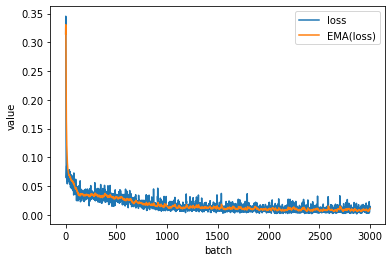

In [43]:
plt.plot(deep_cnn_losses, label='loss')
plt.plot(pd.Series(deep_cnn_losses).ewm(alpha=.1).mean(), label='EMA(loss)')
plt.xlabel('batch')
plt.ylabel('value')
plt.legend();

In [44]:
results = test_model(model=model, n=n, sample_count=iter_count, cnn=True)

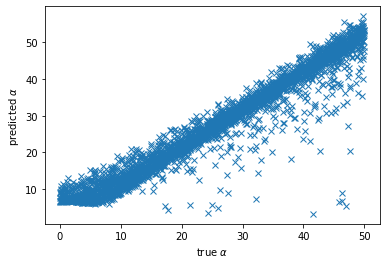

In [45]:
plt.plot(results['true_alpha'], results['predicted_alpha'], 'x')
plt.xlabel(r'true $\alpha$')
plt.ylabel(r'predicted $\alpha$');

In [46]:
results['r2_score_alpha']

0.9159105476340512

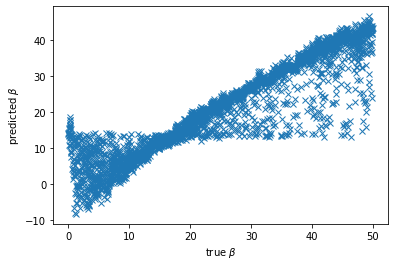

In [47]:
plt.plot(results['true_beta'], results['predicted_beta'], 'x')
plt.xlabel(r'true $\beta$')
plt.ylabel(r'predicted $\beta$');

In [48]:
results['r2_score_beta']

0.7815588164942553

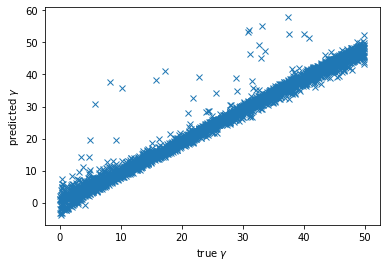

In [49]:
plt.plot(results['true_gamma'], results['predicted_gamma'], 'x')
plt.xlabel(r'true $\gamma$')
plt.ylabel(r'predicted $\gamma$');

In [50]:
results['r2_score_gamma']

0.973467018472945

# Shallow CNN

Now let's try a shallow convolutional neural network.

In [30]:
model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=64, kernel_size=32, activation='relu', input_shape=(n, 1)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(parameter_count, activation='linear'))

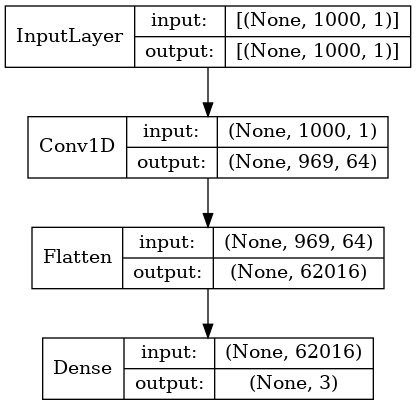

In [31]:
keras.utils.plot_model(model, show_layer_names=False, show_shapes=True)

In [52]:
optimizer = keras.optimizers.SGD(lr=0.01)

In [53]:
model.compile(loss='mse', optimizer=optimizer)

In [54]:
shallow_cnn_losses = train_model(model=model, n=n, batch_count=iter_count, cnn=True)

1/1 [==============================] - 0s 5ms/step - loss: 0.0092


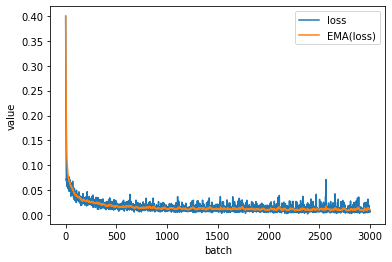

In [55]:
plt.plot(shallow_cnn_losses, label='loss')
plt.plot(pd.Series(shallow_cnn_losses).ewm(alpha=.1).mean(), label='EMA(loss)')
plt.xlabel('batch')
plt.ylabel('value')
plt.legend();

In [56]:
results = test_model(model=model, n=n, sample_count=iter_count, cnn=True)

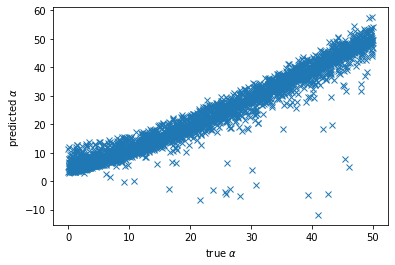

In [57]:
plt.plot(results['true_alpha'], results['predicted_alpha'], 'x')
plt.xlabel(r'true $\alpha$')
plt.ylabel(r'predicted $\alpha$');

In [58]:
results['r2_score_alpha']

0.9252200420482233

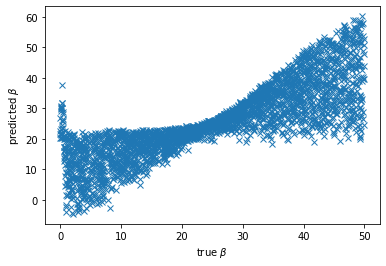

In [59]:
plt.plot(results['true_beta'], results['predicted_beta'], 'x')
plt.xlabel(r'true $\beta$')
plt.ylabel(r'predicted $\beta$');

In [60]:
results['r2_score_beta']

0.7078382196826309

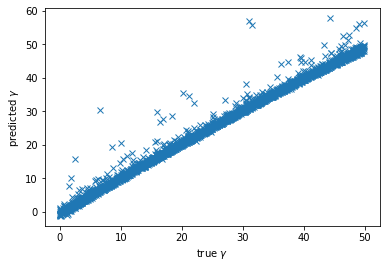

In [61]:
plt.plot(results['true_gamma'], results['predicted_gamma'], 'x')
plt.xlabel(r'true $\gamma$')
plt.ylabel(r'predicted $\gamma$');

In [62]:
results['r2_score_gamma']

0.9904868655371538

# Model comparison

Let us compare the models that we have considered so far.

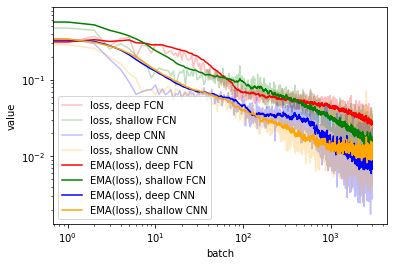

In [63]:
plt.loglog(deep_fcn_losses, label='loss, deep FCN', alpha=.25, color='red')
plt.loglog(shallow_fcn_losses, label='loss, shallow FCN', alpha=.25, color='green')
plt.loglog(deep_cnn_losses, label='loss, deep CNN', alpha=.25, color='blue')
plt.loglog(shallow_cnn_losses, label='loss, shallow CNN', alpha=.25, color='orange')
plt.loglog(pd.Series(deep_fcn_losses).ewm(alpha=.1).mean(), label='EMA(loss), deep FCN', color='red')
plt.loglog(pd.Series(shallow_fcn_losses).ewm(alpha=.1).mean(), label='EMA(loss), shallow FCN', color='green')
plt.loglog(pd.Series(deep_cnn_losses).ewm(alpha=.1).mean(), label='EMA(loss), deep CNN', color='blue')
plt.loglog(pd.Series(shallow_cnn_losses).ewm(alpha=.1).mean(), label='EMA(loss), shallow CNN', color='orange')
plt.xlabel('batch')
plt.ylabel('value')
plt.legend();

We see that the shallow CNN gives the best (lowest) losses, until it is eventually overtaken by the deep CNN.

The following table tabulates the $R^2$ values that we have obtained for each model and for each parameter:

<table>
    <tr>
        <td><b>Model</b></td>
        <td><b>$\alpha$</td>
        <td><b>$\beta$</b></td>
        <td><b>$\gamma$</b></td>
    </tr>
    <tr>
        <td>deep FCN</td>
        <td>89</td>
        <td>14</td>
        <td>96</td>
    </tr>
    <tr>
        <td>shallow FCN</td>
        <td>84</td>
        <td>67</td>
        <td>97</td>
    </tr>
    <tr>
        <td>deep CNN</td>
        <td>92</td>
        <td>78</td>
        <td>97</td>
    </tr>
    <tr>
        <td>shallow CNN</td>
        <td>93</td>
        <td>71</td>
        <td>99</td>
    </tr>
</table>

We observe that $\gamma$ is the easiest parameter to predict; $\beta$ is the hardest. The CNN models dominate the FCN models. None of the models predicts $\beta$ particularly well. There is little difference between the deep and shallow CNN apart from their performance on $\beta$.

# Focus on $\beta$

It appears that our biggest challenge is to estimate $\beta$ successfully.

Let us consider the shallow CNN model again, but train it only on $\beta$.

In [64]:
model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=64, kernel_size=32, activation='relu', input_shape=(n, 1)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation='linear'))

In [65]:
optimizer = keras.optimizers.SGD(lr=0.01)

In [66]:
model.compile(loss='mse', optimizer=optimizer)

In [67]:
model.save('shallow_cnn_beta.h5')

In [68]:
losses = train_model(model=model, n=n, batch_count=iter_count, cnn=True, parameter=['beta'])

1/1 [==============================] - 0s 4ms/step - loss: 0.0187


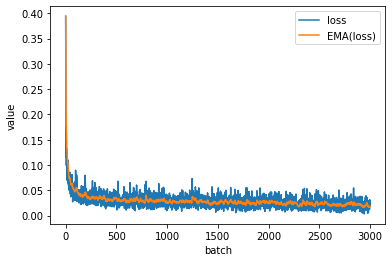

In [69]:
plt.plot(losses, label='loss')
plt.plot(pd.Series(losses).ewm(alpha=.1).mean(), label='EMA(loss)')
plt.xlabel('batch')
plt.ylabel('value')
plt.legend();

In [70]:
results = test_model(model=model, n=n, sample_count=iter_count, cnn=True, parameter=['beta'])

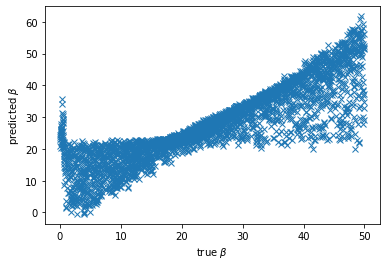

In [71]:
plt.plot(results['true_beta'], results['predicted_beta'], 'x')
plt.xlabel(r'true $\beta$')
plt.ylabel(r'predicted $\beta$');

In [72]:
results['r2_score_beta']

0.7330322265171829

We aren't doing any better than before.

Now let us repeat the same training procedure, but scale the data differently. We'll scale the $y$s the way they would be scaled by `sklearn.preprocessing.MinMaxScaler`.

In [73]:
def train_model_v2(model, n, batch_count, cnn=False, parameter=['alpha', 'beta', 'gamma']):
    losses = []
    for i in range(batch_count):
        inputs = []
        outputs = []
        for j in range(32):
            parameters = generate_parameters()
            ts = np.linspace(0., 2. * np.pi, n)
            ys = generate_ys(ts, **parameters)
            # Here is the difference:
            ys = (ys - np.min(ys)) / (np.max(ys) - np.min(ys)) - .5
            an_input = ys
            inputs.append(an_input)
            an_output = np.array([parameters[p] for p in parameter])
            an_output /= 50.
            outputs.append(an_output)
        the_inputs = np.array(inputs)
        the_outputs = np.array(outputs)
        if cnn:
            the_inputs = np.reshape(the_inputs, (np.shape(the_inputs)[0], np.shape(the_inputs)[1], 1))
        history = model.fit(the_inputs, the_outputs)
        losses.append(history.history['loss'][0])
    return losses

In [74]:
def test_model_v2(model, n, sample_count, cnn=False, parameter=['alpha', 'beta', 'gamma']):
    results = {}
    for p in parameter: results[f'true_{p}'] = []
    the_inputs = []
    for i in range(sample_count):
        parameters = generate_parameters()
        for p in parameter: results[f'true_{p}'].append(parameters[p])
        ys = generate_ys(ts, **parameters)
        # Here is the difference:
        ys = (ys - np.min(ys)) / (np.max(ys) - np.min(ys)) - .5
        the_inputs.append(ys)
    the_inputs = np.array(the_inputs)
    if cnn: the_inputs = np.reshape(the_inputs, (np.shape(the_inputs)[0], np.shape(the_inputs)[1], 1))
    the_outputs = model.predict(the_inputs)
    the_outputs *= 50.
    for i, p in enumerate(parameter):
        results[f'predicted_{p}'] = the_outputs[:,i]
        results[f'r2_score_{p}'] = sklearn.metrics.r2_score(results[f'true_{p}'], results[f'predicted_{p}'])
    return results

We apply the same shallow CNN model as before (we just need to reset it):

In [75]:
model = keras.models.load_model('shallow_cnn_beta.h5')

In [76]:
losses = train_model_v2(model=model, n=n, batch_count=iter_count, cnn=True, parameter=['beta'])

1/1 [==============================] - 0s 4ms/step - loss: 1.0578e-05


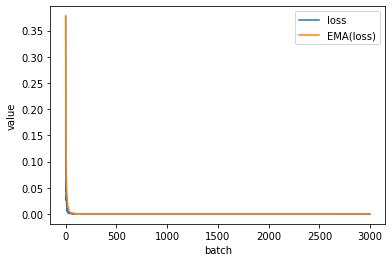

In [77]:
plt.plot(losses, label='loss')
plt.plot(pd.Series(losses).ewm(alpha=.1).mean(), label='EMA(loss)')
plt.xlabel('batch')
plt.ylabel('value')
plt.legend();

In [78]:
results = test_model_v2(model=model, n=n, sample_count=iter_count, cnn=True, parameter=['beta'])

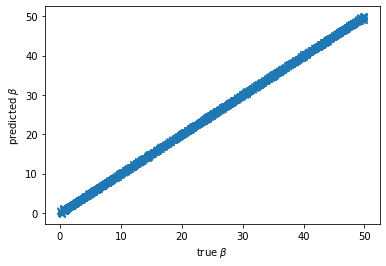

In [79]:
plt.plot(results['true_beta'], results['predicted_beta'], 'x')
plt.xlabel(r'true $\beta$')
plt.ylabel(r'predicted $\beta$');

In [80]:
results['r2_score_beta']

0.9998792911243889

This result is much better than what we've had before. However, the same approach won't estimate $\alpha$ correctly, since we have lost the information about the scale, essential for estimating $\alpha$. Let's confirm this:

In [81]:
model = keras.models.load_model('shallow_cnn_beta.h5')

In [82]:
losses = train_model_v2(model=model, n=n, batch_count=iter_count, cnn=True, parameter=['alpha'])

1/1 [==============================] - 0s 4ms/step - loss: 0.1174


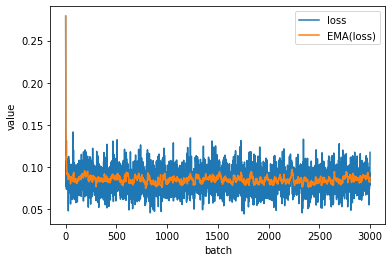

In [83]:
plt.plot(losses, label='loss')
plt.plot(pd.Series(losses).ewm(alpha=.1).mean(), label='EMA(loss)')
plt.xlabel('batch')
plt.ylabel('value')
plt.legend();

In [84]:
results = test_model_v2(model=model, n=n, sample_count=iter_count, cnn=True, parameter=['alpha'])

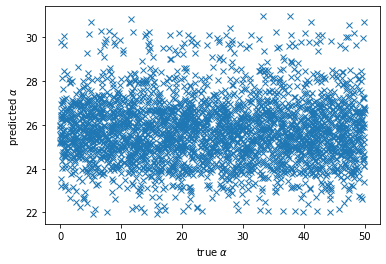

In [85]:
plt.plot(results['true_alpha'], results['predicted_alpha'], 'x')
plt.xlabel(r'true $\alpha$')
plt.ylabel(r'predicted $\alpha$');

In [86]:
results['r2_score_alpha']

-0.018480024830578534

Thus we need the min/max scaler to estimate $\beta$ and yet the same min/max scaler prevents us from estimating $\alpha$. What do we do?

We split the network in two! One half of the network will use the min/max scaler, the other won't. And then we'll combine the results.

In order to be able to do this, we introduce a custom `min_max_scaler` layer that will be applied in the first (horizontal) half of the network. It will be implemented by means of `keras.layers.Lambda`.

In [87]:
def min_max_scaler(new_input):
    return (new_input - tf.reduce_min(new_input, axis=1, keepdims=True)) / (tf.reduce_max(new_input, axis=1, keepdims=True) - tf.reduce_min(new_input, axis=1, keepdims=True)) - .5

In [88]:
inputs = keras.Input(shape=(n, 1))

x = keras.layers.Lambda(min_max_scaler)(inputs)
x = keras.layers.Conv1D(filters=64, kernel_size=32, activation='relu')(x)
x = keras.layers.Flatten()(x)

y = keras.layers.Conv1D(filters=64, kernel_size=32, activation='relu')(inputs)
y = keras.layers.Flatten()(y)

xy = keras.layers.add([x, y])

z = keras.layers.Dense(64, activation='relu')(xy)

outputs = keras.layers.Dense(3, activation='linear')(z)
model = keras.Model(inputs, outputs)

In [89]:
optimizer = keras.optimizers.SGD(lr=0.01)

In [90]:
model.compile(loss='mse', optimizer=optimizer)

In [91]:
custom_architecture_losses = train_model(model=model, n=n, batch_count=iter_count, cnn=True)

1/1 [==============================] - 0s 8ms/step - loss: 6.9667e-04


In [92]:
results = test_model(model=model, n=n, sample_count=iter_count, cnn=True)

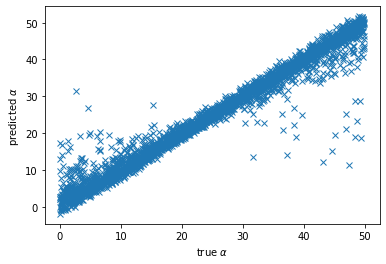

In [93]:
plt.plot(results['true_alpha'], results['predicted_alpha'], 'x')
plt.xlabel(r'true $\alpha$')
plt.ylabel(r'predicted $\alpha$');

In [94]:
results['r2_score_alpha']

0.9581618115380359

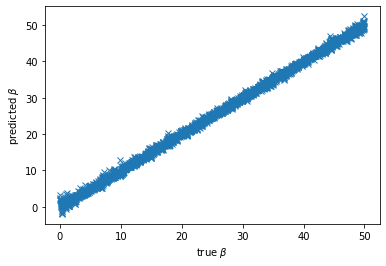

In [95]:
plt.plot(results['true_beta'], results['predicted_beta'], 'x')
plt.xlabel(r'true $\beta$')
plt.ylabel(r'predicted $\beta$');

In [96]:
results['r2_score_beta']

0.9984551428652606

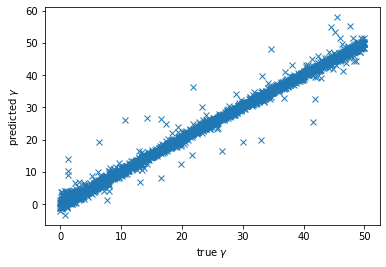

In [97]:
plt.plot(results['true_gamma'], results['predicted_gamma'], 'x')
plt.xlabel(r'true $\gamma$')
plt.ylabel(r'predicted $\gamma$');

In [98]:
results['r2_score_gamma']

0.9919638038703776

## Final model comparison

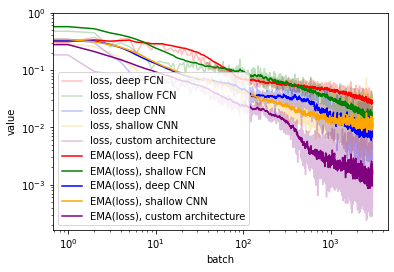

In [100]:
plt.loglog(deep_fcn_losses, label='loss, deep FCN', alpha=.25, color='red')
plt.loglog(shallow_fcn_losses, label='loss, shallow FCN', alpha=.25, color='green')
plt.loglog(deep_cnn_losses, label='loss, deep CNN', alpha=.25, color='blue')
plt.loglog(shallow_cnn_losses, label='loss, shallow CNN', alpha=.25, color='orange')
plt.loglog(custom_architecture_losses, label='loss, custom architecture', alpha=.25, color='purple')
plt.loglog(pd.Series(deep_fcn_losses).ewm(alpha=.1).mean(), label='EMA(loss), deep FCN', color='red')
plt.loglog(pd.Series(shallow_fcn_losses).ewm(alpha=.1).mean(), label='EMA(loss), shallow FCN', color='green')
plt.loglog(pd.Series(deep_cnn_losses).ewm(alpha=.1).mean(), label='EMA(loss), deep CNN', color='blue')
plt.loglog(pd.Series(shallow_cnn_losses).ewm(alpha=.1).mean(), label='EMA(loss), shallow CNN', color='orange')
plt.loglog(pd.Series(custom_architecture_losses).ewm(alpha=.1).mean(), label='EMA(loss), custom architecture', color='purple')
plt.xlabel('batch')
plt.ylabel('value')
plt.legend();

<table>
    <tr>
        <td><b>Model</b></td>
        <td><b>$\alpha$</td>
        <td><b>$\beta$</b></td>
        <td><b>$\gamma$</b></td>
    </tr>
    <tr>
        <td>deep FCN</td>
        <td>89</td>
        <td>14</td>
        <td>96</td>
    </tr>
    <tr>
        <td>shallow FCN</td>
        <td>84</td>
        <td>67</td>
        <td>97</td>
    </tr>
    <tr>
        <td>deep CNN</td>
        <td>92</td>
        <td>78</td>
        <td>97</td>
    </tr>
    <tr>
        <td>shallow CNN</td>
        <td>93</td>
        <td>71</td>
        <td>99</td>
    </tr>
    <tr>
        <td>custom architecture</td>
        <td>96</td>
        <td>100</td>
        <td>99</td>
    </tr>
</table>

Notice that, not only does the custom architecture enable us to estimate $\beta$; by combining the information from the left and right halves of the model we improve our estimate of $\alpha$.